In [220]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import json
import math
from hole_data import hole_data, post_hole_data
from dataclasses import dataclass
from sklearn.cluster import DBSCAN
from scipy.optimize import least_squares
from scipy.optimize import minimize

Simulation

In [222]:
# Function to calculate the endpoints of a mirror given center, length, and angle
def calculate_mirror_endpoints(center, length, angle):
    half_length = length / 2
    angle_rad = np.radians(angle)
    start = (
        center[0] - half_length * np.cos(angle_rad),
        center[1] - half_length * np.sin(angle_rad),
    )
    end = (
        center[0] + half_length * np.cos(angle_rad),
        center[1] + half_length * np.sin(angle_rad),
    )
    return start, end

# Function to find the intersection of two lines
def find_intersection(p1, p2, p3, p4, eps=1e-9):
    # Laser direction (t parameter)
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4

    r = np.array([x2 - x1, y2 - y1], dtype=float)  # laser direction
    s = np.array([x4 - x3, y4 - y3], dtype=float)  # mirror direction

    rxs = r[0]*s[1] - r[1]*s[0]
    if abs(rxs) < eps:
        return None  # parallel / nearly parallel

    qp = np.array([x3 - x1, y3 - y1], dtype=float)

    # Solve p1 + t r = p3 + u s
    t = (qp[0]*s[1] - qp[1]*s[0]) / rxs
    u = (qp[0]*r[1] - qp[1]*r[0]) / rxs

    # Mirror segment constraint: u in [0, 1]
    # Laser ray constraint: t >= 0 (in front of start)
    if t >= -eps and -eps <= u <= 1 + eps:
        return (x1 + t*r[0], y1 + t*r[1])

    return None

# Function to calculate the reflection of a laser beam
def reflect_laser(laser_start, laser_angle, mirrors, last_mirror):
    laser_angle_rad = np.radians(laser_angle)
    laser_far_end = (
        laser_start[0] + np.cos(laser_angle_rad) * 1000,
        laser_start[1] + np.sin(laser_angle_rad) * 1000,
    )
    
    closest_intersection = None
    closest_mirror = None
    min_distance = float('inf')

    # Find the closest intersection, ignoring the last mirror hit
    for mirror in mirrors:
        if mirror == last_mirror:
            continue
        intersection = find_intersection(laser_start, laser_far_end, mirror[0], mirror[1])
        if intersection is not None:
            distance = np.linalg.norm(np.array(intersection) - np.array(laser_start))
            if distance < min_distance:
                min_distance = distance
                closest_intersection = intersection
                closest_mirror = mirror

    if closest_intersection is None:
        return None, None, None  # No reflection
    
    # Reflection calculation
    mirror_start, mirror_end = closest_mirror
    mirror_vector = np.array([mirror_end[0] - mirror_start[0], mirror_end[1] - mirror_start[1]])
    mirror_length = np.linalg.norm(mirror_vector)
    mirror_unit_vector = mirror_vector / mirror_length
    normal_vector = np.array([-mirror_unit_vector[1], mirror_unit_vector[0]])
    incident_vector = np.array([closest_intersection[0] - laser_start[0], closest_intersection[1] - laser_start[1]])
    reflection_vector = (
        incident_vector - 2 * np.dot(incident_vector, normal_vector) * normal_vector
    )
    reflected_end = (
        closest_intersection[0] + reflection_vector[0],
        closest_intersection[1] + reflection_vector[1],
    )
    return closest_intersection, reflected_end, closest_mirror

In [223]:
# Function to calculate distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Simulate laser reflections with length calculation
def simulate_laser_with_length(laser_start, laser_angle, mirrors, max_reflections=36):
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None
    laser_path = [laser_start]  # Track laser path

    for _ in range(max_reflections):
        intersection, reflected_end, hit_mirror = reflect_laser(current_position, current_angle, mirrors, last_mirror)
        if intersection is None:
            # No more intersections; add final endpoint and break
            laser_far_end = (
                current_position[0] + np.cos(np.radians(current_angle)) * 1000,
                current_position[1] + np.sin(np.radians(current_angle)) * 1000,
            )
            laser_path.append(laser_far_end)
            break

        # Update the path and continue simulation
        laser_path.append(intersection)
        current_position = intersection
        current_angle = np.degrees(np.arctan2(
            reflected_end[1] - intersection[1],
            reflected_end[0] - intersection[0],
        ))
        last_mirror = hit_mirror

    # Calculate total laser length
    total_length = sum(calculate_distance(laser_path[i], laser_path[i + 1]) for i in range(len(laser_path) - 2))
    return laser_path, total_length

def extend_line(p1, p2):
    # Calculate the length of the line
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    # Extend the line in both directions
    new_p1 = (p1[0] - 0.73*dx, p1[1] - 0.73*dy)  # Extend p1 backwards
    new_p2 = (p2[0] + 0.73*dx, p2[1] + 0.73*dy)  # Extend p2 forwards
    return new_p1, new_p2

def create_orthogonal_line_at_endpoint(endpoint, other_endpoint, length=44):
    """Create an orthogonal line of the specified length at a given endpoint."""
    # Calculate the direction vector of the original line
    dx = other_endpoint[0] - endpoint[0]
    dy = other_endpoint[1] - endpoint[1]
    
    # Get orthogonal direction
    orthogonal_dx = -dy
    orthogonal_dy = dx
    magnitude = np.sqrt(orthogonal_dx**2 + orthogonal_dy**2)
    unit_dx = orthogonal_dx / magnitude
    unit_dy = orthogonal_dy / magnitude

    # Compute the two endpoints of the orthogonal line
    ortho_p1 = (endpoint[0] + unit_dx * length, endpoint[1] + unit_dy * length)
    ortho_p2 = (endpoint[0] - unit_dx * length, endpoint[1] - unit_dy * length)
    return ortho_p1, ortho_p2

def select_furthest_orthogonal_line(endpoint, ortho_p1, ortho_p2, reference_x=100):
    """Select the orthogonal line endpoint furthest away from reference_x."""
    # Calculate distances from reference_x for each orthogonal endpoint
    dist_ortho_p1 = abs(ortho_p1[0] - reference_x)
    dist_ortho_p2 = abs(ortho_p2[0] - reference_x)
    
    # Return the endpoint further from reference_x
    if dist_ortho_p1 > dist_ortho_p2:
        return (endpoint, ortho_p1)
    else:
        return (endpoint, ortho_p2)

def process_mirrors(mirrors):
    doubled_lines = []
    orthogonal_lines = []
    
    for p1, p2 in mirrors:
        # Double the length of the original line
        extended_p1, extended_p2 = extend_line(p1, p2)
        doubled_lines.append((extended_p1, extended_p2))

        # Create orthogonal lines at the endpoints of the doubled line
        ortho_p1_a, ortho_p1_b = create_orthogonal_line_at_endpoint(extended_p1, extended_p2)
        ortho_p2_a, ortho_p2_b = create_orthogonal_line_at_endpoint(extended_p2, extended_p1)
        
        # Select only the orthogonal line furthest from x=100
        orthogonal_lines.append(select_furthest_orthogonal_line(extended_p1, ortho_p1_a, ortho_p1_b))
        orthogonal_lines.append(select_furthest_orthogonal_line(extended_p2, ortho_p2_a, ortho_p2_b))

    return doubled_lines, orthogonal_lines

In [224]:
# The diameter of usable mirror. Given 1 inch mirror: 25.4mm. Clear aperture from spec sheet: 22.9mm.
# 3mm diameter beam. 22.9 - (3/2) = 21.4 mm
mirror_lengths = [21.4, 21.4, 21.4, 21.4]

# Set up the laser
laser_start = (0, 100)
laser_angle = 0  # Initial laser angle in degrees

In [225]:
#Quad Cell Locations
qc_1 = np.array([-100, 137])
qc_2 = np.array([-300, 190])

In [226]:
def execution(m1cx, m1cy, m2cx, m2cy, m3cx, m3cy, m4cx, m4cy, m1a, m2a, m3a, m4a, reflec_points):
    mirrors = []

    # MIRROR CONFIGURATION
    mirror_centers = [(m1cx, m1cy), (m2cx, m2cy), (m3cx, m3cy), (m4cx, m4cy)]
    mirror_angles = [m1a, m2a, m3a, m4a] #in degrees

    for center, length, angle in zip(mirror_centers, mirror_lengths, mirror_angles):
        mirrors.append(calculate_mirror_endpoints(center, length, angle))

    # Initialize plot
    plt.figure(figsize=(12, 10))
    plt.scatter(*laser_start, color='red', label="Laser Source", linewidth=1)

    #Piezo mount outline visualizer
    doubled_lines, orthogonal_lines = process_mirrors(mirrors)

    # Draw the mirrors
    for i, mirror in enumerate(mirrors):
        plt.plot([mirror[0][0], mirror[1][0]], [mirror[0][1], mirror[1][1]], color = 'black', linewidth=3)

    #Draw piezo mirror mounts outline for fitting purposes
    for i, mirror in enumerate(doubled_lines):
        plt.plot([mirror[0][0], mirror[1][0]], [mirror[0][1], mirror[1][1]], linewidth=1, color = 'black')

    for i, mirror in enumerate(orthogonal_lines):
        plt.plot([mirror[0][0], mirror[1][0]], [mirror[0][1], mirror[1][1]], linewidth=1, color = 'black')

    # Simulate laser reflections
    max_reflections = 36
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None
    reflection_count = 0

    for i in range(max_reflections):
        intersection, reflected_end, hit_mirror = reflect_laser(current_position, current_angle, mirrors, last_mirror)
        if intersection is None:
            # No more intersections
            plt.plot(
                [current_position[0], current_position[0] + np.cos(np.radians(current_angle)) * 1000],
                [current_position[1], current_position[1] + np.sin(np.radians(current_angle)) * 1000],
                'g--'
            )
            break

        # Draw the laser and reflection
        plt.plot([current_position[0], intersection[0]], [current_position[1], intersection[1]], 'r-', linewidth =1)
        #plt.plot([intersection[0], reflected_end[0]], [intersection[1], reflected_end[1]], 'g-')
        #plt.scatter(*intersection, color='orange', label=f"Intersection {i+1}")
    
        # Update for next reflection
        current_position = intersection
        current_angle = np.degrees(np.arctan2(
            reflected_end[1] - intersection[1],
            reflected_end[0] - intersection[0],
        ))
        last_mirror = hit_mirror
        reflection_count += 1

    laser_path, total_length = simulate_laser_with_length(laser_start, laser_angle, mirrors)

    #Indicate where to cut off laser distance calculation (x=?)
    a=laser_path[-2]
    b=laser_path[-1]
    x=0
    slope = (b[1] - a[1]) / (b[0] - a[0])
    y = a[1] + slope * (x - a[0])
    x_point = (x, y)
    distance = np.sqrt((x_point[0] - a[0])**2 + (x_point[1] - a[1])**2)

    #Identify if the exiting beam gets clipped with M4
    a = np.array([a[0], a[1]])
    b = np.array([b[0], b[1]])
    m = np.array([m4cx, m4cy])
    v = b - a
    d = np.array([np.cos(np.deg2rad(m4a)), np.sin(np.deg2rad(m4a))])
    A = np.column_stack((v, -d))
    t, s = np.linalg.solve(A, m - a)
    if 0 <= t <= 1:
        p = a + t * v
        dist = np.linalg.norm(p - m)
    else:
        # Beam does not pass near M4 — no clipping possible
        print("Beam does not intersect M4 region")
        dist = np.inf

    if dist >= 14.3: # Mirror diameter = 25.4mm. laser beam diameter = 3mm. (25.4/2) + (3/2) + 0.1(<- additional edge of mirror error)
        print("NOT CLIPPED, room to spare: ", dist-14.3, "mm")
    else:
        print("CLIPPED, ", dist-14.3, 'mm too much')
        
    print("Laser Path:", laser_path)
    print("Total Laser Length:", total_length+distance, "mm")
    print("Total Number of Reflection (N_R) = ", reflection_count)

    # Finalize plot
    plt.xlim(-310, 250)
    plt.ylim(-10, 210)
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Laser Reflection with Multiple Mirrors")
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.grid(True, linewidth=0.3)
    plt.plot([qc_1[0],qc_1[0]],[qc_1[1] - 2, qc_1[1] + 2], linewidth=4, label='QC1') # Quadcell Detector 1
    plt.plot([qc_2[0],qc_2[0]],[qc_2[1] - 2, qc_2[1] + 2], linewidth=4, label='QC2') # Quadcell Detector 2
    x,y = zip(*reflec_points)
    plt.scatter(x, y, color='blue', marker='o')
    plt.legend(prop={'size': 8})
    plt.show()

In [227]:
def execution_identifier(m1cx, m1cy, m2cx, m2cy, m3cx, m3cy, m4cx, m4cy, m1a, m2a, m3a, m4a):
    mirrors = []

    # MIRROR CONFIGURATION
    mirror_centers = [(m1cx, m1cy), (m2cx, m2cy), (m3cx, m3cy), (m4cx, m4cy)]
    mirror_angles = [m1a, m2a, m3a, m4a] #in degrees

    for center, length, angle in zip(mirror_centers, mirror_lengths, mirror_angles):
        mirrors.append(calculate_mirror_endpoints(center, length, angle))

    #Piezo mount outline visualizer
    doubled_lines, orthogonal_lines = process_mirrors(mirrors)

    # Simulate laser reflections
    max_reflections = 36
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None

    laser_path, total_length = simulate_laser_with_length(laser_start, laser_angle, mirrors)

    #Indicate where to cut off laser distance calculation (x=?)
    a=laser_path[-2]
    b=laser_path[-1]
    x=0
    slope = (b[1] - a[1]) / (b[0] - a[0])
    y = a[1] + slope * (x - a[0])
    x_point = (x, y)
    distance = np.sqrt((x_point[0] - a[0])**2 + (x_point[1] - a[1])**2)

    last_two = laser_path[-2:]
    exit_slope = (last_two[1][1]-last_two[0][1])/(last_two[1][0]-last_two[0][0])
    y_int=last_two[1][1]-exit_slope*last_two[1][0]
    y100=exit_slope*-100+y_int
    y200=exit_slope*-200+y_int
    y300=exit_slope*-300+y_int
    y525=exit_slope*-525+y_int
    print(f"Exit angle: {exit_slope}")
    print(f"Total length: {total_length + distance}")
    print(f"y100: {y100-137}")
    print(f"y200: {y200-163.5}")
    print(f"y300: {y300-190}")
    print(f"y525: {y525-249.63}")

    return exit_slope, total_length + distance, y100-137, y300-190

ArUcos

In [229]:
intrinsics_path = r"C:\Users\alber\Documents\hardware_project\intrinsics_fisheye.json" # Download from Github

with open(intrinsics_path, "r") as f:
    intr = json.load(f)

K = np.array(intr["K"], dtype=np.float64)
D = np.array(intr["D"], dtype=np.float64)  # shape (N,1) or (1,N) is fine
img_w = intr["image_width"]
img_h = intr["image_height"]

In [230]:
obj_xyz = []
img_uv  = []

# Table holes: Z = 0
for X, Y, u, v in hole_data:
    obj_xyz.append([X, Y, 0.0])
    img_uv.append([u, v])

# Post tops: Z = H
for X, Y, u, v, H in post_hole_data:
    obj_xyz.append([X, Y, H])
    img_uv.append([u, v])

obj_xyz = np.array(obj_xyz, dtype=np.float64)
img_uv  = np.array(img_uv,  dtype=np.float64)

print("Using", obj_xyz.shape[0], "points for pose estimation.")

success, rvec_cw, tvec_cw = cv.solvePnP(
    objectPoints=obj_xyz,
    imagePoints=img_uv,
    cameraMatrix=K,
    distCoeffs=D,
    flags=cv.SOLVEPNP_ITERATIVE
)

if not success:
    raise RuntimeError("solvePnP failed")

R_cw, _ = cv.Rodrigues(rvec_cw)  # world -> camera
t_cw = tvec_cw                   # 3x1

R_wc = R_cw.T                    # camera -> world
t_wc = -R_wc @ t_cw              # camera center in world coords

Using 160 points for pose estimation.


Transition Functions

In [232]:
def pixel_to_world_on_plane(u, v, H_in=0.0, override_cam_height=None):
    pts = np.array([[[u, v]]], dtype=np.float64)
    rays_norm = cv.undistortPoints(pts, K, D)  # pinhole model
    x, y = rays_norm[0,0]
    d_cam = np.array([x, y, 1.0], dtype=np.float64)

    d_w = R_wc @ d_cam

    C_w = t_wc.reshape(3).copy()
    if override_cam_height is not None:
        C_w[2] = float(override_cam_height)

    lam = (H_in - C_w[2]) / d_w[2]
    Pw = C_w + lam * d_w
    return float(Pw[0]), float(Pw[1])

In [233]:
def world_to_pixel(X, Y, Z):
    obj = np.array([[[X, Y, Z]]], dtype=np.float64)  # (1,1,3)
    img_proj, _ = cv.projectPoints(obj, rvec_cw, tvec_cw, K, D)
    u, v = img_proj.reshape(2)
    return float(u), float(v)

Reading ArUcos

[detect] Found 12 candidate markers using DICT_4X4_100
[filter] Kept 12 markers from allowed IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


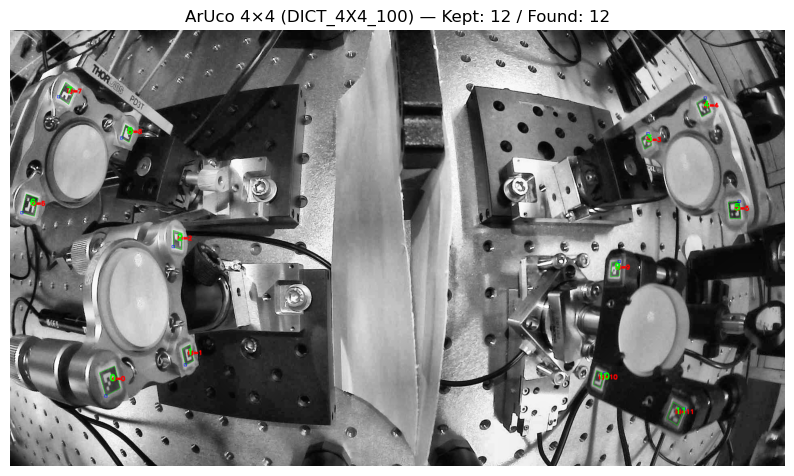

[out] Ready: detected list with 12 kept markers (ids, corners, centers).
  id=0, center=[247.47974396 868.20132446], TL=[236.91712952 905.74713135]
  id=10, center=[1457.95343018  864.47241211], TL=[1472.  851.]
  id=9, center=[1498.94189453  592.0496521 ], TL=[1509.  573.]
  id=6, center=[ 49.39485168 433.40627289], TL=[ 29.04291534 451.5256958 ]
  id=11, center=[1648.25  950.  ], TL=[1670.  938.]


In [235]:
# Config
img_path = "1-9_light3.jpg"   # set your image path
dict_name = "DICT_4X4_100"                 # choose your 4x4 family: DICT_4X4_50/100/250/1000
allowed_ids = {0,1,2,3,4,5,6,7,8,9,10,11}   # <<< replace with YOUR printed IDs
use_CLAHE = True                           # True: local equalization; False: global hist eq
resize_factor = 1.0                         # e.g., 1.5 if markers are tiny/pixelated

# Load + grayscale + enhance
img_bgr = cv.imread(img_path)
assert img_bgr is not None, f"Could not read image at {img_path}"
gray = cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY)

# Optional upsample for tiny markers
if resize_factor != 1.0:
    gray = cv.resize(gray, None, fx=resize_factor, fy=resize_factor, interpolation=cv.INTER_CUBIC)
    img_bgr = cv.resize(img_bgr, None, fx=resize_factor, fy=resize_factor, interpolation=cv.INTER_CUBIC)

# Contrast enhancement
if use_CLAHE:
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_eq = clahe.apply(gray)
else:
    gray_eq = cv.equalizeHist(gray)

# ArUco detection (4x4 dict)
aruco_dict = cv.aruco.getPredefinedDictionary(getattr(cv.aruco, dict_name))

# Detector parameters (tuned for small/low-contrast markers)
try:
    params = cv.aruco.DetectorParameters()
except AttributeError:
    params = cv.aruco.DetectorParameters_create()

params.adaptiveThreshWinSizeMin = 3
params.adaptiveThreshWinSizeMax = 45
params.adaptiveThreshWinSizeStep = 3
params.adaptiveThreshConstant   = 7
params.minMarkerPerimeterRate   = 0.01
params.maxMarkerPerimeterRate   = 5.0
params.minCornerDistanceRate    = 0.01
params.cornerRefinementMethod   = cv.aruco.CORNER_REFINE_SUBPIX

# Detect (handle both new/old OpenCV APIs)
try:
    detector = cv.aruco.ArucoDetector(aruco_dict, params)
    corners, ids, rejected = detector.detectMarkers(gray_eq)
except AttributeError:
    corners, ids, rejected = cv.aruco.detectMarkers(gray_eq, aruco_dict, parameters=params)

total_found = 0 if ids is None else len(ids)
print(f"[detect] Found {total_found} candidate markers using {dict_name}")

# Filter to allowed_ids
filtered_corners, filtered_ids = [], []
rejected_by_id = []  # for visualization/debug

if ids is not None:
    for c, i in zip(corners, ids.flatten()):
        if int(i) in allowed_ids:
            filtered_corners.append(c)
            filtered_ids.append([int(i)])   # keep as nested list for OpenCV
        else:
            rejected_by_id.append((c, int(i)))

if len(filtered_ids) == 0:
    print("[filter] No allowed markers detected!")
else:
    print(f"[filter] Kept {len(filtered_ids)} markers from allowed IDs: {sorted(allowed_ids)}")

# Convert to numpy for downstream OpenCV calls
ids_kept = np.array(filtered_ids, dtype=np.int32) if filtered_ids else None
corners_kept = filtered_corners

# Build a nice visualization
#   - green boxes = kept (allowed)
#   - red boxes   = rejected-by-ID (optional)
vis = cv.cvtColor(gray_eq, cv.COLOR_GRAY2RGB)

# Draw kept markers in green
if ids_kept is not None and len(ids_kept) > 0:
    cv.aruco.drawDetectedMarkers(vis, corners_kept, ids_kept)
    for c, i in zip(corners_kept, ids_kept.flatten()):
        center = c.reshape(-1,2).mean(axis=0).astype(int)
        cv.putText(vis, f"{int(i)}", tuple(center), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2, cv.LINE_AA)

# Optionally draw rejected-by-ID in red (helps you see the false positive)
for c, i in rejected_by_id:
    pts = c.reshape(4,2).astype(int)
    cv.polylines(vis, [pts], True, (255,0,0), 2, cv.LINE_AA)
    center = pts.mean(axis=0).astype(int)
    cv.putText(vis, f"rej {int(i)}", tuple(center), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2, cv.LINE_AA)

plt.figure(figsize=(10,10))
plt.imshow(vis)
plt.title(f"ArUco 4×4 ({dict_name}) — Kept: {0 if ids_kept is None else len(ids_kept)} / Found: {total_found}")
plt.axis('off')
plt.show()

# Collect outputs for downstream use
detected = []
if ids_kept is not None:
    for c, i in zip(corners_kept, ids_kept.flatten()):
        pts = c.reshape(4,2).astype(float)    # TL, TR, BR, BL
        center = pts.mean(axis=0)
        # If you upsampled (resize_factor != 1), pts/center are already in the resized pixel space.
        # If you want original-image coordinates instead, divide by resize_factor here.
        detected.append({"id": int(i), "corners": pts, "center": center})

print(f"[out] Ready: detected list with {len(detected)} kept markers (ids, corners, centers).")
# Example peek:
for d in detected[:5]:
    print(f"  id={d['id']}, center={d['center']}, TL={d['corners'][0]}")

In [236]:
def camera_arucos(img_path): # Basically the above code, but so that we only get the ArUco values
    # --- Config ---
    dict_name = "DICT_4X4_100"
    allowed_ids = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
    resize_factor = 1.5
    
    img_bgr = cv.imread(img_path)
    if img_bgr is None:
        return []
    
    gray = cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY)

    if resize_factor != 1.0:
        gray = cv.resize(gray, None, fx=resize_factor, fy=resize_factor, interpolation=cv.INTER_CUBIC)

    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_eq = clahe.apply(gray)

    aruco_dict = cv.aruco.getPredefinedDictionary(getattr(cv.aruco, dict_name))
    try:
        params = cv.aruco.DetectorParameters()
    except AttributeError:
        params = cv.aruco.DetectorParameters_create()

    params.adaptiveThreshWinSizeMin = 3
    params.adaptiveThreshWinSizeMax = 45
    params.cornerRefinementMethod = cv.aruco.CORNER_REFINE_SUBPIX

    try:
        detector = cv.aruco.ArucoDetector(aruco_dict, params)
        corners, ids, _ = detector.detectMarkers(gray_eq)
    except AttributeError:
        corners, ids, _ = cv.aruco.detectMarkers(gray_eq, aruco_dict, parameters=params)

    # Temporary list to hold (id, (x, y)) tuples
    found_markers = []
    
    if ids is not None:
        for c, i in zip(corners, ids.flatten()):
            marker_id = int(i)
            if marker_id in allowed_ids:
                pts = c.reshape(4, 2)
                center = pts.mean(axis=0)
                
                # Scale back to original resolution
                if resize_factor != 1.0:
                    center = center / resize_factor
                
                found_markers.append((marker_id, tuple(center)))

    # --- Sorting Logic ---
    # Sort by the first element of the tuple (the ID)
    found_markers.sort(key=lambda x: x[0])

    # Extract only the coordinates from the sorted list
    sorted_centers = [coords for marker_id, coords in found_markers]

    return sorted_centers

In [237]:
detected

[{'id': 0,
  'corners': array([[236.91712952, 905.74713135],
         [221.15776062, 848.6439209 ],
         [258.89666748, 832.11553955],
         [272.94741821, 886.29870605]]),
  'center': array([247.47974396, 868.20132446])},
 {'id': 10,
  'corners': array([[1472.        ,  851.        ],
         [1463.        ,  887.        ],
         [1444.        ,  877.        ],
         [1452.8137207 ,  842.88964844]]),
  'center': array([1457.95343018,  864.47241211])},
 {'id': 9,
  'corners': array([[1509.        ,  573.        ],
         [1508.76757812,  608.1986084 ],
         [1488.        ,  611.        ],
         [1490.        ,  576.        ]]),
  'center': array([1498.94189453,  592.0496521 ])},
 {'id': 6,
  'corners': array([[ 29.04291534, 451.5256958 ],
         [ 39.60976028, 405.76287842],
         [ 68.86595917, 415.62512207],
         [ 60.06077194, 460.71139526]]),
  'center': array([ 49.39485168, 433.40627289])},
 {'id': 11,
  'corners': array([[1670.,  938.],
         [1

In [238]:
coords = camera_arucos(img_path = "1-9_light3.jpg") # Whatever image you want to analyze
coords

[(247.7262, 868.4553),
 (440.16666, 805.3333),
 (415.31912, 520.595),
 (1576.3334, 275.83334),
 (1718.4238, 191.82213),
 (1794.5382, 445.54004),
 (49.616405, 433.68484),
 (141.06822, 156.5858),
 (290.30096, 256.1205),
 (1498.1642, 592.37256),
 (1458.3375, 865.0551),
 (1648.3334, 950.0)]

In [239]:
heights = {0: 4.722167,
    1: 3.4291,
    2: 3.4210290000000003,
    3: 3.471474,
    4: 4.776629,
    5: 4.76645,
    6: 4.774986,
    7: 4.780836,
    8: 3.47397,
    9: 3.32363,
    10: 3.280905,
    11: 4.705506000000001}

In [240]:
shifts_LR = {0: 0.017658,
    1: 0.01895,
    2: -0.01143,
    3: -0.00125,
    4: -0.004104,
    5: 0.01212,
    6: 0.03053,
    7: 0.01846,
    8: 0.018335,
    9: -0.01785,
    10: -0.013066,
    11: 0.039195
}

In [241]:
shifts_UD = {0: -0.000583,
    1: 0.01630,
    2: 0.009529,
    3: -0.005546,
    4: -0.018201,
    5: -0.03784,
    6: 0.000196,
    7: 0.001556,
    8: 0.00097,
    9: -0.02202,
    10: -0.021515,
    11: -0.012064
}

In [242]:
def get_center_for_id(detected, tag_id):
    for d in detected:
        if d["id"] == tag_id:
            return float(d["center"][0]), float(d["center"][1])  # (u,v)
    raise ValueError(f"Marker ID {tag_id} not found")

def world_point_from_id(tag_id, detected):
    u, v = get_center_for_id(detected, tag_id)
    H = heights[tag_id]
    X, Y = pixel_to_world_on_plane(u, v, H_in=H, override_cam_height=None)
    return np.array([X, Y, H], dtype=np.float64)

def mirror_center_from_ids(id0, id1, id2):

    P0 = world_point_from_id(id0, detected)
    P1 = world_point_from_id(id1, detected)
    P2 = world_point_from_id(id2, detected)

    M = 0.5 * (P0 + P2)

    return M

In [243]:
P0 = world_point_from_id(0, detected)
P1 = world_point_from_id(1, detected)
P2 = world_point_from_id(2, detected)

P3 = world_point_from_id(3, detected)
P4 = world_point_from_id(4, detected)
P5 = world_point_from_id(5, detected)

P6 = world_point_from_id(6, detected)
P7 = world_point_from_id(7, detected)
P8 = world_point_from_id(8, detected)

P9 = world_point_from_id(9, detected)
P10 = world_point_from_id(10, detected)
P11 = world_point_from_id(11, detected)
print(P0, P1, P2)
print(P3, P4, P5)
print(P6, P7, P8)
print(P9, P10, P11)

[-2.53349049 -1.59009184  4.722167  ] [-2.54915358 -1.59268672  3.4291    ] [-2.68884631 -0.29582368  3.421029  ]
[3.55393897 1.13932328 3.471474  ] [3.25803026 1.00258669 4.776629  ] [ 3.40841832 -0.17749727  4.76645   ]
[-3.9076537  -0.07262725  4.774986  ] [-3.70106895  1.15727095  4.780836  ] [-3.85537078  1.24595851  3.47397   ]
[ 2.57809194 -0.69210701  3.32363   ] [ 2.37502308 -2.08752056  3.280905  ] [ 2.27892489 -2.09620752  4.705506  ]


Correcting ArUco sticker placements:

In [245]:
def unit(v, eps=1e-12):
    n = np.linalg.norm(v)
    if n < eps:
        raise ValueError("Zero/near-zero vector encountered.")
    return v / n

def plane_normal(Pa, Pb, Pc):
    # normal to the plane through (Pa,Pb,Pc)
    return unit(np.cross(Pb - Pa, Pc - Pa))

def project_onto_plane(direction, n_hat):
    # remove the component along the plane normal
    d = direction - np.dot(direction, n_hat) * n_hat
    return unit(d)

def apply_shifts_to_mirror(Ps, shift_lr_in, shift_ud_in,
                           lr_global_axis=np.array([0., 1., 0.]),  # "y"
                           ud_global_axis=np.array([0., 0., 1.])): # "z"
    Pa, Pb, Pc = Ps
    n_hat = plane_normal(Pa, Pb, Pc)

    # In-plane directions corresponding to "global y" and "global z"
    dir_lr = project_onto_plane(lr_global_axis, n_hat)
    dir_ud = project_onto_plane(ud_global_axis, n_hat)

    return dir_lr, dir_ud, n_hat

def correct_points(points_by_id, shifts_LR, shifts_UD, mirrors):
    corrected = dict(points_by_id)  # copy

    for tri in mirrors:
        i0, i1, i2 = tri
        P0, P1, P2 = points_by_id[i0], points_by_id[i1], points_by_id[i2]

        dir_lr, dir_ud, n_hat = apply_shifts_to_mirror(
            (P0, P1, P2),
            shifts_LR, shifts_UD,
            lr_global_axis=np.array([0., 1., 0.]),  # "y"
            ud_global_axis=np.array([0., 0., 1.])   # "z"
        )

        for i in tri:
            d_lr = shifts_LR.get(i, 0.0)
            d_ud = shifts_UD.get(i, 0.0)
            corrected[i] = points_by_id[i] + d_lr * dir_lr + d_ud * dir_ud

    return corrected


In [246]:
points_by_id = {
    0: np.array(P0), 1: np.array(P1), 2: np.array(P2),
    3: np.array(P3), 4: np.array(P4), 5: np.array(P5),
    6: np.array(P6), 7: np.array(P7), 8: np.array(P8),
    9: np.array(P9), 10: np.array(P10), 11: np.array(P11),
}

mirrors = [(0,1,2), (3,4,5), (6,7,8), (9,10,11)]

corrected = correct_points(points_by_id, shifts_LR, shifts_UD, mirrors)

P0_corr = corrected[0]

In [247]:
corrected

{0: array([-2.53538708, -1.57253601,  4.72160734]),
 1: array([-2.55098267, -1.57382415,  3.44542378]),
 2: array([-2.68750711, -0.30717555,  3.4305422 ]),
 3: array([3.55536015, 1.1382422 , 3.46611398]),
 4: array([3.26269451, 0.99903706, 4.75903839]),
 5: array([ 3.41568502, -0.16437651,  4.72929608]),
 6: array([-3.90267192, -0.04251333,  4.77453881]),
 7: array([-3.69787718,  1.17544932,  4.78199152]),
 8: array([-3.85227249,  1.26402581,  3.47454687]),
 9: array([ 2.57692876, -0.70997782,  3.3014849 ]),
 10: array([ 2.37452241, -2.10065355,  3.25931009]),
 11: array([ 2.28540585, -2.05754629,  4.69384723])}

In [248]:
P0  = corrected[0]
P1  = corrected[1]
P2  = corrected[2]

P3  = corrected[3]
P4  = corrected[4]
P5  = corrected[5]

P6  = corrected[6]
P7  = corrected[7]
P8  = corrected[8]

P9  = corrected[9]
P10 = corrected[10]
P11 = corrected[11]

In [249]:
def offset_point_negative_x(id0, id1, id2, neg=True, offset=0.045):
    P0 = corrected[id0]
    P1 = corrected[id1]
    P2 = corrected[id2]
    M = 0.5*(P0 + P2)

    # Plane normal (not normalized)
    n = np.cross(P1 - P0, P2 - P0)
    n_norm = np.linalg.norm(n)
    if n_norm < 1e-9:
        raise ValueError("Points are collinear — no plane normal.")
    n_hat = n / n_norm   # unit normal

    # Choose the normal pointing in negative x direction
    if neg == True:
        if n_hat[0] < 0:
            n_use = n_hat
        else:
            n_use = -n_hat
    else:
        if n_hat[0] < 0:
            n_use = -n_hat
        else:
            n_use = n_hat

    P_offset = M + offset * n_use

    return P_offset

In [250]:
M1_C_Re = offset_point_negative_x(0,1,2)
M2_C_Re = offset_point_negative_x(3,4,5, neg=False)
M3_C_Re = offset_point_negative_x(6,7,8)
M4_C_Re = mirror_center_from_ids(9,10,11)

In [251]:
M1_C_Re

array([-2.65618529, -0.94467136,  4.07662636])

In [252]:
def to_sim(M1_C_Re, M2_C_Re, M3_C_Re, M4_C_Re):
    calib_M1 = np.array([-160,-109])
    M1_sim = np.array([-2.5, M1_C_Re[1]])
    M1_sim = M1_sim * 25.4
    diff = calib_M1 - M1_sim
    M1_to_sim = -(M1_sim + diff)

    M2_sim = np.array([M2_C_Re[0], M2_C_Re[1]]) * 25.4
    M3_sim = np.array([M3_C_Re[0], M3_C_Re[1]]) * 25.4
    M4_sim = np.array([M4_C_Re[0], M4_C_Re[1]]) * 25.4

    M2_to_sim = -(M2_sim + diff)
    M3_to_sim = -(M3_sim + diff)
    M4_to_sim = -(M4_sim + diff)

    return M1_to_sim, M2_to_sim, M3_to_sim, M4_to_sim

In [253]:
def pt_to_sim(x,y):
    calib_irl = [-2.65720102, -0.94574237] #IRL x,y point corresponds to the calib_sim (x,y) point in the simulation for transition
    calib_sim = [-160,-109]

    diff_x, diff_y = (x-calib_irl[0])*25.4, (y-calib_irl[1])*25.4

    loc_x, loc_y = -(diff_x+calib_sim[0]), -(diff_y+calib_sim[1])

    return loc_x, loc_y

In [254]:
Mirror_positions = to_sim(M1_C_Re, M2_C_Re, M3_C_Re, M4_C_Re)
Mirror_positions

(array([160., 109.]),
 array([ 6.86442039, 72.4989324 ]),
 array([196.10604237,  69.30499643]),
 array([ 34.81588627, 120.41694205]))

Angles

In [256]:
theta_M1 = math.atan2(P2[1] - P1[1], P2[0] - P1[0])      # radians
theta_deg_M1 = math.degrees(theta_M1)                    # degrees
theta_M2 = math.atan2(P5[1] - P4[1], P5[0] - P4[0])      # radians
theta_deg_M2 = math.degrees(theta_M2)                    # degrees
theta_M3 = math.atan2(P7[1] - P6[1], P7[0] - P6[0])      # radians
theta_deg_M3 = math.degrees(theta_M3)                    # degrees
theta_M4 = math.atan2(P10[1] - P9[1], P10[0] - P9[0])    # radians
theta_deg_M4 = math.degrees(theta_M4)                    # degrees

In [257]:
theta_deg_M1, theta_deg_M2, theta_deg_M3, theta_deg_M4

(96.15181834538902, -82.50850998700264, 80.45526608085441, -98.28098622697375)

8 Parameters Result:

In [259]:
Mirror_positions

(array([160., 109.]),
 array([ 6.86442039, 72.4989324 ]),
 array([196.10604237,  69.30499643]),
 array([ 34.81588627, 120.41694205]))

In [260]:
theta_deg_M1, theta_deg_M2, theta_deg_M3, theta_deg_M4

(96.15181834538902, -82.50850998700264, 80.45526608085441, -98.28098622697375)

Laser Reflection Points

In [262]:
laser_height = 4.087 # inches

In [263]:
def pca_elongation(points_xy):
    """
    points_xy: (N,2) array of [x,y] in patch coords.
    returns (ratio, major_sigma, minor_sigma, angle_rad)
    """
    pts = points_xy.astype(float)
    pts -= pts.mean(axis=0, keepdims=True)

    C = np.cov(pts.T)
    vals, vecs = np.linalg.eigh(C)          # vals sorted ascending
    minor, major = np.sqrt(vals[0] + 1e-9), np.sqrt(vals[1] + 1e-9)
    ratio = major / minor
    angle = np.arctan2(vecs[1,1], vecs[0,1])  # direction of major axis
    return ratio, major, minor, angle


def split_cluster_k2(points_xy, n_iter=20):
    """
    Very small k-means for k=2 on points_xy.
    Returns centers (2,2) in patch coords.
    """
    pts = points_xy.astype(float)

    # init: pick two farthest points (good for peanuts)
    d2 = ((pts[:,None,:] - pts[None,:,:])**2).sum(axis=2)
    i, j = np.unravel_index(np.argmax(d2), d2.shape)
    c1, c2 = pts[i].copy(), pts[j].copy()

    for _ in range(n_iter):
        d1 = ((pts - c1)**2).sum(axis=1)
        d2 = ((pts - c2)**2).sum(axis=1)
        m1 = d1 <= d2
        m2 = ~m1
        if m1.sum() == 0 or m2.sum() == 0:
            break
        new_c1 = pts[m1].mean(axis=0)
        new_c2 = pts[m2].mean(axis=0)
        if np.allclose(new_c1, c1) and np.allclose(new_c2, c2):
            break
        c1, c2 = new_c1, new_c2

    return np.vstack([c1, c2])

In [264]:
def postprocess_split_peanuts(clusters, radius_split=18.0, elong_split=1.8, min_sep=6.0):
    """
    Splits clusters that look like two touching spots.
    Returns a new cluster list (some clusters replaced by two subclusters).
    """
    new_clusters = []
    next_label = 1000  # labels for split children

    for c in clusters:
        pts = np.array(c["points"], dtype=float)   # patch coords [x,y]
        if len(pts) < 20:
            new_clusters.append(c)
            continue

        ratio, major, minor, _ = pca_elongation(pts)

        # decide whether to split
        if (c["radius"] > radius_split) or (ratio > elong_split):
            centers2 = split_cluster_k2(pts)

            # reject split if the two centers are basically on top of each other
            if np.linalg.norm(centers2[0] - centers2[1]) < min_sep:
                new_clusters.append(c)
                continue

            # build two child clusters based on assignment
            d1 = ((pts - centers2[0])**2).sum(axis=1)
            d2 = ((pts - centers2[1])**2).sum(axis=1)
            m1 = d1 <= d2
            m2 = ~m1

            for m, center in [(m1, centers2[0]), (m2, centers2[1])]:
                sub_pts = pts[m]
                if len(sub_pts) < 5:
                    continue
                dist = np.linalg.norm(sub_pts - center, axis=1)
                radius = float(dist.max())
                x_min, y_min = np.min(sub_pts, axis=0)
                x_max, y_max = np.max(sub_pts, axis=0)

                new_clusters.append({
                    **c,
                    "label": int(next_label),
                    "center": center.tolist(),
                    "radius": radius,
                    "size": int(len(sub_pts)),
                    "points": sub_pts.tolist(),
                    "bbox": [float(x_min), float(x_max), float(y_min), float(y_max)],
                    "density": float(len(sub_pts) / (np.pi * radius**2)) if radius > 0 else 0.0,
                    "was_split": True,
                })
                next_label += 1
        else:
            new_clusters.append(c)

    # sort biggest first like you already do
    new_clusters.sort(key=lambda x: x["size"], reverse=True)
    return new_clusters

In [265]:
THRESHOLD = 200

def find_clusters_with_circles(patch, threshold=200, eps=5.0, min_samples=5, show=True, title=""):
    y_coords, x_coords = np.where(patch > threshold)

    if len(x_coords) == 0:
        if show:
            print("No points above threshold!")
        return []

    coordinates = np.column_stack([x_coords, y_coords])

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(coordinates)

    unique_labels = set(labels)
    clusters = []

    for label in unique_labels:
        if label == -1:
            continue
        mask = labels == label
        cluster_points = coordinates[mask]

        center = np.mean(cluster_points, axis=0)
        distances = np.linalg.norm(cluster_points - center, axis=1)
        radius = np.max(distances)

        x_min, y_min = np.min(cluster_points, axis=0)
        x_max, y_max = np.max(cluster_points, axis=0)

        clusters.append({
            'label': int(label),
            'center': center.tolist(),      # [x, y] in PATCH coords
            'radius': float(radius),
            'size': int(len(cluster_points)),
            'points': cluster_points.tolist(),
            'bbox': [float(x_min), float(x_max), float(y_min), float(y_max)],
            'density': float(len(cluster_points) / (np.pi * radius**2)) if radius > 0 else 0.0
        })

    clusters.sort(key=lambda x: x['size'], reverse=True)

    clusters = postprocess_split_peanuts(clusters, radius_split=20.0, elong_split=2, min_sep=8.0)

    if show:
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        axes[0].imshow(patch, cmap='gray')
        colors = plt.cm.tab10(np.linspace(0, 1, max(len(clusters), 1)))

        for i, cluster in enumerate(clusters):
            color = colors[i]
            center = cluster['center']
            radius = cluster['radius']

            circle = plt.Circle(center, radius, color=color, fill=False, linewidth=2, alpha=0.7)
            axes[0].add_patch(circle)
            axes[0].scatter(center[0], center[1], color=color, s=100, marker='x', linewidths=2)
            axes[0].text(center[0], center[1], f'C{i}', color='white', fontsize=12, fontweight='bold',
                         ha='center', va='center',
                         bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8))

        axes[0].set_title(title or f'Found {len(clusters)} Cluster(s)')
        axes[0].axis('equal')

        axes[1].axis('off')
        if clusters:
            summary = "CLUSTER CENTERS:\n\n"
            for i, cluster in enumerate(clusters):
                summary += f"Cluster {i} (Label {cluster['label']}):\n"
                summary += f"  Center: ({cluster['center'][0]:.1f}, {cluster['center'][1]:.1f})\n"
                summary += f"  Radius: {cluster['radius']:.1f} px\n"
                summary += f"  Size: {cluster['size']} points\n"
                summary += f"  Density: {cluster['density']:.3f} pts/px²\n"
                summary += f"  BBox: [{cluster['bbox'][0]:.0f}-{cluster['bbox'][1]:.0f}, {cluster['bbox'][2]:.0f}-{cluster['bbox'][3]:.0f}]\n\n"
            axes[1].text(0.05, 0.95, summary, fontfamily='monospace',
                         verticalalignment='top', fontsize=10)

        plt.tight_layout()
        plt.show()

    return clusters


def clusters_in_roi(gray, roi, threshold=200, eps=5.0, min_samples=5, show=True):
    x1, y1, x2, y2 = roi
    patch = gray[y1:y2, x1:x2]

    clusters = find_clusters_with_circles(
        patch, threshold=threshold, eps=eps, min_samples=min_samples,
        show=show, title=f"ROI {roi} | threshold={threshold}, eps={eps}"
    )

    # Add full-image centers to each cluster dict
    for c in clusters:
        cx, cy = c["center"]  # patch coords
        c["center_full"] = [cx + x1, cy + y1]

    return clusters

In [266]:
img_bgr = cv.imread("1-9_dark.jpg")

In [267]:
# Build grayscale once
gray = cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY)

rois = {
    "M1": (200, 500, 400, 800),
    "M2": (1600, 200, 1750, 450),
    "M3": (100, 200, 250, 450),
    "M4": (1500, 600, 1700, 850),
}

In [268]:
def process_all_rois(gray_img, rois, threshold, eps=5.0, min_samples=5, show=False):
    results = {}
    for name, roi in rois.items():
        clusters = clusters_in_roi(
            gray_img, roi,
            threshold=threshold,
            eps=eps,
            min_samples=min_samples,
            show=show
        )
        results[name] = clusters
    return results

In [269]:
def reflec_pts_cam(gray_img, eps=5.0, min_samples=5, show=False):
    # Uses global rois + THRESHOLD to FIND clusters
    all_clusters = process_all_rois(
        gray_img,
        rois=rois,
        threshold=THRESHOLD,
        eps=eps,
        min_samples=min_samples,
        show=show
    )

    grouped = {k: [] for k in rois.keys()}

    # ---- Collect and group centers ----
    for clusters in all_clusters.values():
        for c in clusters:
            x, y = c["center_full"]

            for name, (x0, y0, x1, y1) in rois.items():
                if x0 <= x <= x1 and y0 <= y <= y1:
                    grouped[name].append([float(x), float(y)])
                    break
    return grouped

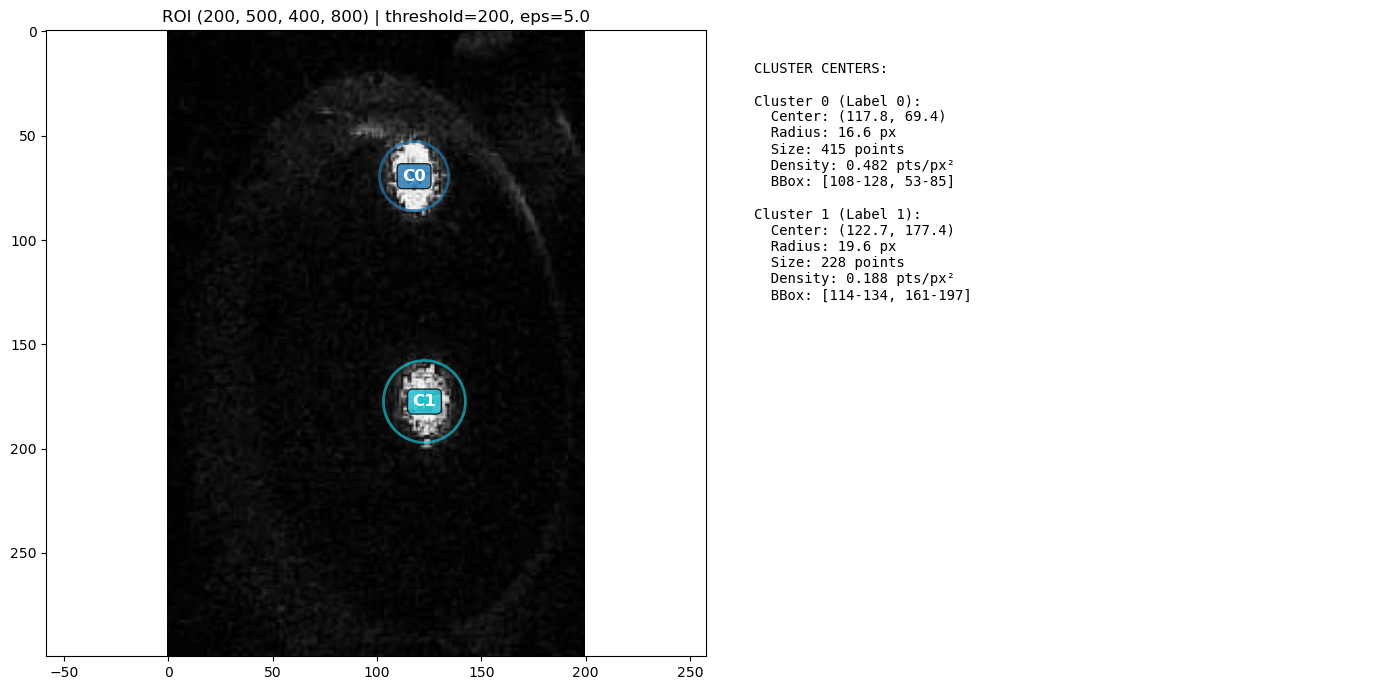

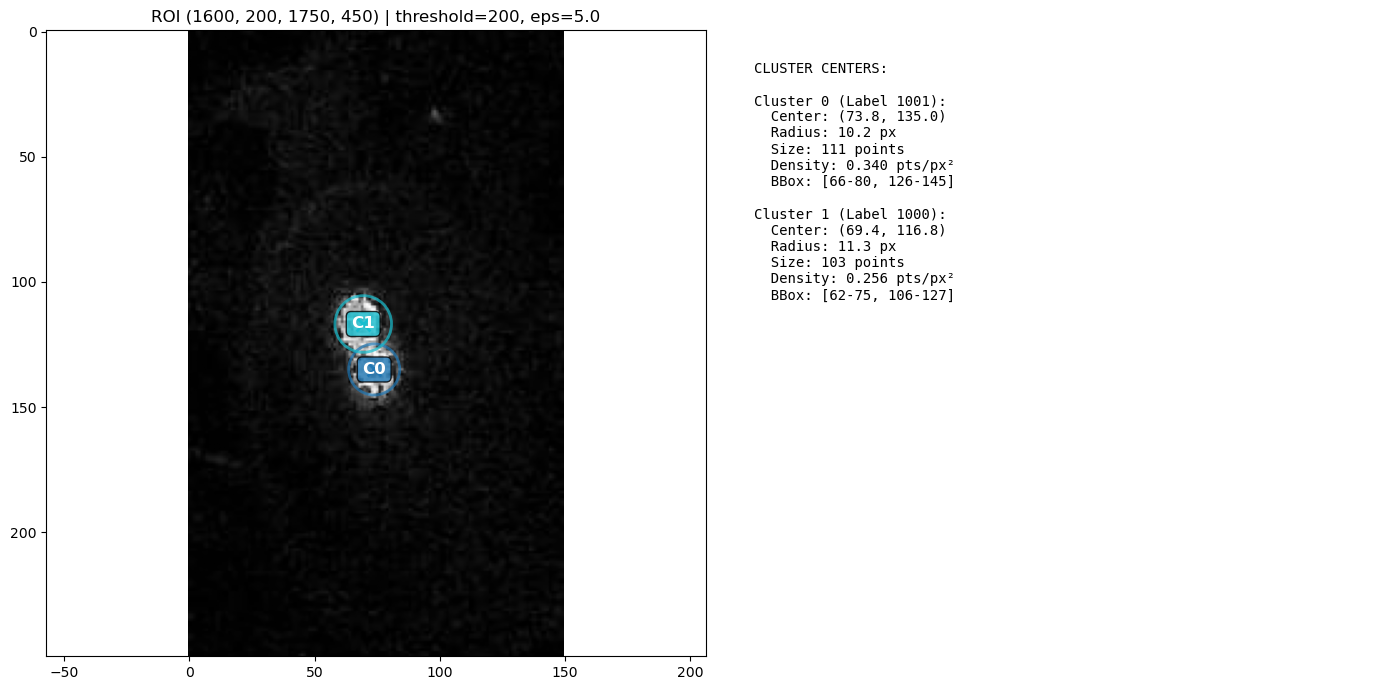

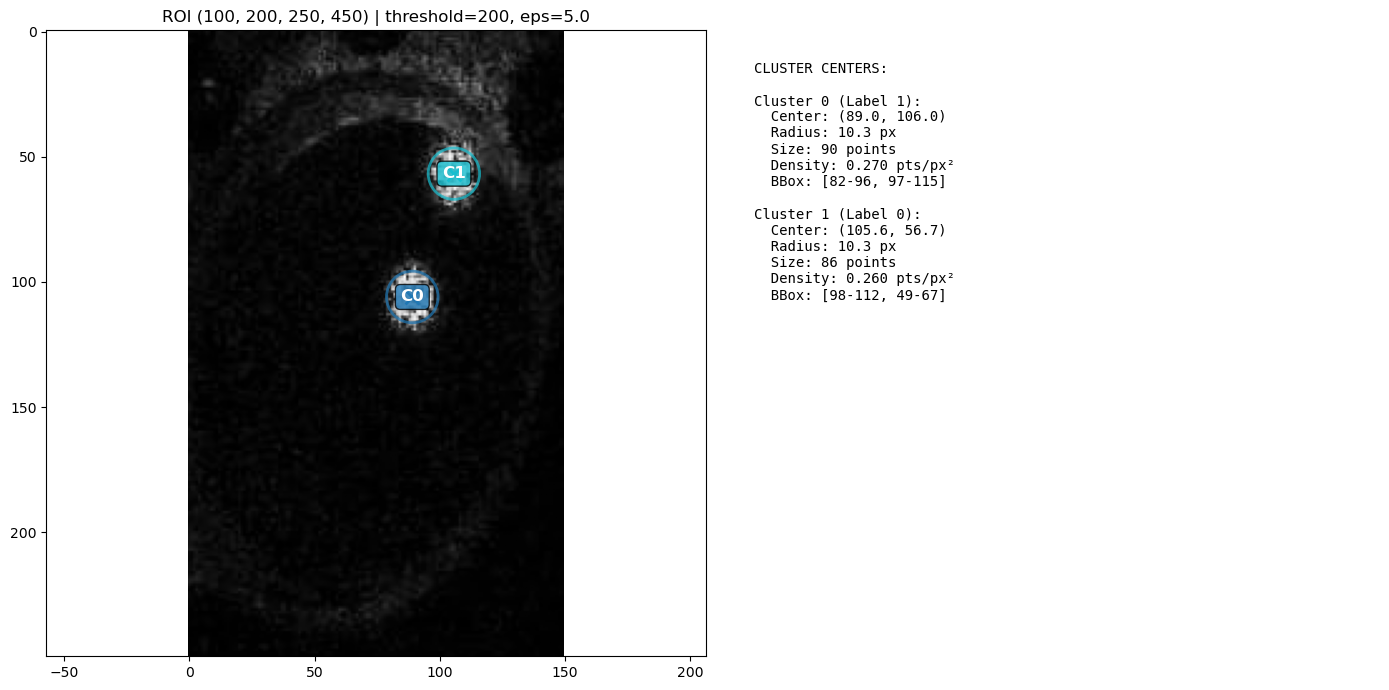

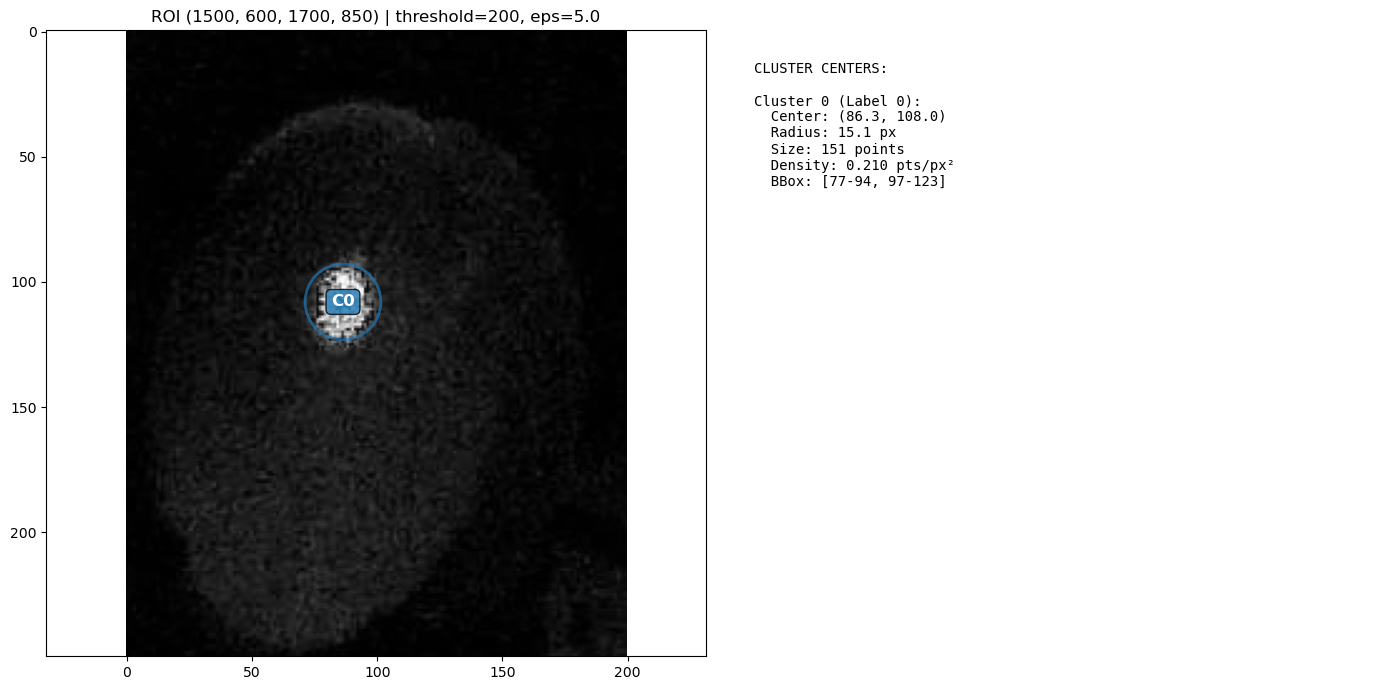

{'M1': [[317.75180722891565, 569.3975903614457],
  [322.7105263157895, 677.4078947368421]],
 'M2': [[1673.7747747747749, 334.9549549549549],
  [1669.388349514563, 316.7864077669903]],
 'M3': [[189.0, 305.9888888888889], [205.61627906976744, 256.74418604651163]],
 'M4': [[1586.3046357615895, 707.9735099337748]]}

In [270]:
pts = reflec_pts_cam(gray, show=True)   # show=True if you want the ROI plots
pts

In [271]:
pts = reflec_pts_cam(gray, show=False)   # show=True if you want the ROI plots
pts

{'M1': [[317.75180722891565, 569.3975903614457],
  [322.7105263157895, 677.4078947368421]],
 'M2': [[1673.7747747747749, 334.9549549549549],
  [1669.388349514563, 316.7864077669903]],
 'M3': [[189.0, 305.9888888888889], [205.61627906976744, 256.74418604651163]],
 'M4': [[1586.3046357615895, 707.9735099337748]]}

In [272]:
results_irl = [pixel_to_world_on_plane(x, y, laser_height) for coords in pts.values() for x, y in coords]

In [273]:
results_irl

[(-2.710207168503575, -0.5802047084735823),
 (-2.6734765039163904, -0.9970269858996395),
 (3.569758036062832, 0.5654643828556439),
 (3.5693465702358953, 0.6670619000778165),
 (-3.927036713766471, 0.7286680734320289),
 (-3.8869473115038096, 0.9911154629115874),
 (2.4397571269642997, -1.2291710689200395)]

In [274]:
results_sim = [pt_to_sim(x, y) for x,y in results_irl]

In [275]:
results_sim

[(161.3463561719908, 99.71534339722899),
 (160.41339729147631, 110.30262924385084),
 (1.8352399760040896, 70.61534847746664),
 (1.8456912080082475, 68.03477154002346),
 (192.25382662166837, 66.46997473682647),
 (191.23555580419676, 59.80381104404568),
 (30.537263067106807, 116.199088952569)]

Plotting everything:

NOT CLIPPED, room to spare:  4.6392377658010595 mm
Laser Path: [(0, 100), (160.97005590224083, 100.0), (7.645446407059893, 66.55963419628742), (197.13547749421028, 75.42729021161257), (-731.5523650464836, 446.28965163038936)]
Total Laser Length: 719.8695435573152 mm
Total Number of Reflection (N_R) =  3


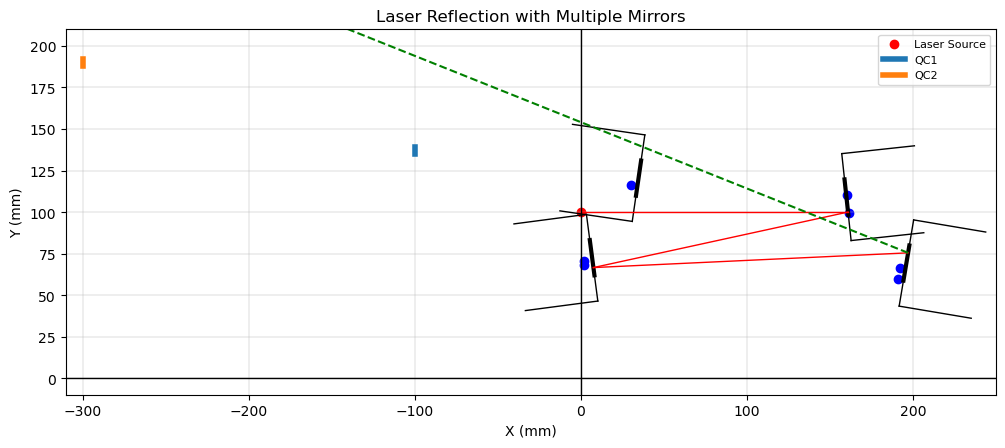

In [277]:
execution(Mirror_positions[0][0], Mirror_positions[0][1], #M1, (x,y)
          Mirror_positions[1][0], Mirror_positions[1][1], #M2, (x,y)
          Mirror_positions[2][0], Mirror_positions[2][1], #M3, (x,y)
          Mirror_positions[3][0], Mirror_positions[3][1], #M4, (x,y)
          theta_deg_M1, theta_deg_M2, theta_deg_M3, theta_deg_M4, results_sim) # Angle from positive x-axis (M1, M2, M3, M4)